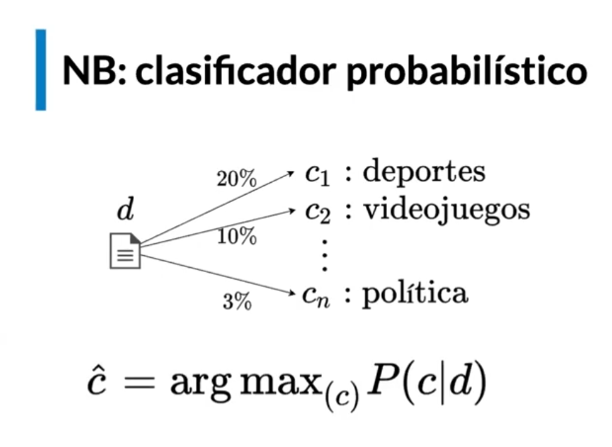

$$ P(c|d) = P(d|c)\times P(c) $$
$$\hat{c} = {\arg \max}_{(c)}\log{P(c)}
 +\sum_{i=1}^n
\log{ P(f_i \vert c)}
$$
$$
P(f_i \vert c) = \frac{C(f_i, c)+1}{C(c) + \vert V \vert}
$$

In [1]:
import numpy as np
import pandas as pd

In [2]:
!rm /tmp/datasets -rf
!git clone https://github.com/pachocamacho1990/datasets /tmp/datasets

Cloning into '/tmp/datasets'...
remote: Enumerating objects: 39, done.


remote: Total 39 (delta 0), reused 0 (delta 0), pack-reused 39
Receiving objects: 100% (39/39), 41.91 MiB | 16.49 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [3]:
!unzip /tmp/datasets/email/plaintext/corpus1.zip -d /tmp/extracted < <(yes)

Archive:  /tmp/datasets/email/plaintext/corpus1.zip
replace /tmp/extracted/corpus1/spam/2967.2004-11-28.GP.spam.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: /tmp/extracted/corpus1/spam/2967.2004-11-28.GP.spam.txt  
replace /tmp/extracted/corpus1/spam/3787.2005-02-10.GP.spam.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: /tmp/extracted/corpus1/spam/3787.2005-02-10.GP.spam.txt  
replace /tmp/extracted/corpus1/spam/1711.2004-07-26.GP.spam.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: /tmp/extracted/corpus1/spam/1711.2004-07-26.GP.spam.txt  
replace /tmp/extracted/corpus1/spam/1825.2004-08-14.GP.spam.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: /tmp/extracted/corpus1/spam/1825.2004-08-14.GP.spam.txt  
replace /tmp/extracted/corpus1/spam/1503.2004-07-07.GP.spam.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: /tmp/extracted/corpus1/spam/1503.2004-07-07.GP.spam.txt  
replace /tmp/extracted/corpus1/spam/1400.2004-06-21.GP.spam.txt? [y]es, [n]o, 

In [4]:
from pathlib import Path
import re

In [5]:
df = pd.DataFrame(columns=['data', 'class'])
for dir in Path('/tmp/extracted/corpus1/').iterdir():
    if not dir.is_dir():
        continue
    for file in dir.iterdir():
        with open(file, 'r', encoding='latin-1') as f:
            df.loc[len(df)] = {'data': f.read(), 'class': dir.name}

In [6]:
df.head()

,data,class
0,"Subject: enron / hpl actuals for december 14 ,...",ham
1,"Subject: re : nom change - effective oct 26 , ...",ham
2,Subject: february production estimate\n- - - -...,ham
3,Subject: neon for feb 28\nattached are the que...,ham
4,Subject: january production estimate\ndaren / ...,ham


In [7]:
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from nltk import FreqDist
import xarray as xr

2023-08-09 01:48:04.869128: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 01:48:07.218742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 01:48:07.232882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 01

In [8]:
nlp = English()
tokenizer = Tokenizer(nlp.vocab)

In [9]:
class NaiveBayesClassifier:
    nlp: English
    tokenizer: Tokenizer

    def tokenize(self, phrase: str):
        return [t.text.lower() for t in self.tokenizer(phrase)]
    
    def word_counts(self, phrase: list):
        return dict(FreqDist(phrase))
    
    def fit(self, data: pd.Series, classes: pd.Series = None):
        
        n = len(data)

        self.unique_classes = set(classes)
        self.vocab = set()

        tokenized = data.apply(self.tokenize)
        self.counted = tokenized.apply(self.word_counts)

        ## Class count C(c)
        self.class_count = classes \
            .value_counts(normalize=True) \
            .rename({('index' if not (sub := classes.index.name) else sub): 'class'})
        self.class_count.name = 'class_count'
        ## P(c)
        self.class_prob = np.log(self.class_count)

        ## Word-class count C(w|c) = C(w,c) / C(c)
        # self.word_class_count = self
        aux = pd.DataFrame(columns=[ 'word', 'class', 'count'])
        for c in self.unique_classes:
            filt = classes == c
            subset = self.counted[filt]

            worder = subset.apply(lambda x: x.keys()).explode()
            counter = subset.apply(lambda x: x.values()).explode()

            aux = pd.concat([aux, pd.DataFrame({'class': c, 'word': worder,'count': counter})])
        chunk_results = []

        # Process data in chunks
        chunk_size = 1000
        num_chunks = int(np.ceil(len(aux) / chunk_size))
        for chunk_index in range(num_chunks):
            start_idx = chunk_index * chunk_size
            end_idx = (chunk_index + 1) * chunk_size
            chunk = aux[start_idx:end_idx]

            # Group and aggregate operations on the chunk
            grouped_chunk = chunk.groupby(['word', 'class'])['count'].sum()
            
            # Append chunk results to the list
            chunk_results.append(grouped_chunk)
        self.word_class_count = pd.concat(chunk_results).reset_index()
        return self.word_class_count
        # return aux.groupby(['word', 'class']).sum()

    def predict(self, data: pd.DataFrame | pd.Series):
        results = []
        data = data.to_list()
        dataset = None
        for text in data:
            words = set(self.tokenize(text))
            scoreProb = {}
            for word in words:
                if word not in self.word_class_count.word.unique(): continue
                dataset = self.word_class_count[self.word_class_count['word'] == word]
                print(dataset)
                for c in self.unique_classes:
                    filt_class = dataset['class'] == c
                    dataset = dataset[filt_class]
                    log_wordClassProb = np.log(
                        (dataset['count'] + 1.) / (self.class_count[dataset['class']] + len(self.word_class_count) / len(self.unique_classes))
                    )
                    scoreProb[c] = scoreProb.get(c, self.class_prob[self.class_prob == c]) + log_wordClassProb
                arg_maxprob = np.argmax(np.array(list(scoreProb.values())))
                
                results.append(list(scoreProb.keys())[arg_maxprob])
        return results

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
data_train, data_test, clases_train, clases_test = train_test_split(df.data, df['class'], test_size=0.10, random_state=42)

In [11]:
classifier = NaiveBayesClassifier()
classifier.tokenizer = tokenizer
test = classifier.fit(data_train, clases_train)
test

,word,class,count
0,\n,spam,128
1,\n,spam,1
2,!,spam,22
3,"""",spam,1
4,#,spam,9
...,...,...,...
326600,with,ham,5
326601,works,ham,1
326602,year,ham,1
326603,you,ham,5


In [12]:
clases_preddict = classifier.predict(data_test)
print(clases_preddict)

       word class count
42061   hou  spam     8
135265  hou   ham     4
135969  hou   ham    32
136634  hou   ham    13
137236  hou   ham     9
...     ...   ...   ...
323544  hou   ham     9
324135  hou   ham     3
324839  hou   ham    53
325501  hou   ham    11
326048  hou   ham    29

[289 rows x 3 columns]


TypeError: loop of ufunc does not support argument 0 of type float which has no callable log method